 **UNIVERSIDADE FEDERAL DE SÃO CARLOS** - *CAMPUS* SOROCABA
<br>
 Bacharelado em Ciência da Computação
<br><br>
**NOVAS TECNOLOGIAS EM BANCO DE DADOS**
<br>
Profª. Dra. Sahudy Montenegro González


# **PROJETO PRÁTICO**
Relatório - Fase Final
<br>
Grupo 01 - Tema: Receitas Tudogostoso
<br>

*   Felipe Ottoni Pereira
*   Letícia Almeida Paulino de Alencar Ferreira

<br>
Sorocaba, 25 de Fevereiro de 2025


## **DESCRIÇÃO DO TEMA**

---

O site **TudoGostoso** é uma plataforma de receitas culinárias, que oferece uma ampla variedade de pratos e tipos de comida. É composto por receitas enviadas por usuários, cada receita específica é agrupada em subcategorias que representam a comida ou bebida que está se preparando, que por sua vez são agrupadas em uma categoria maior referente ao tipo daquele prato. Então por exemplo: há diversas receitas específicas de bolo de chocolate (feitas por diversos usuários), que são agrupadas em uma subcategoria de bolos de chocolate que por sua vez são agrupados numa categoria de bolos e tortas.
Cada receita específica é constituída por avaliações (o número total e a média), número de comentários, tempo de preparo, nível de dificuldade (baixa, média ou alta), nível do custo (baixo, médio ou alto), lista de ingredientes, lista de utensílios e modo de preparo.
<br><br>
Pensando como um gestor do site, definimos que para termos de BI e valor agregado, seria de maior relevância e interesse ter métricas e análises utilizando como granularidade subcategoria ao invés de receita unitária, além disso uma hierarquia também permitiria análises para um nível mais alto: categoria. Além disso, para granularidade máxima também utilizaremos custo e dificuldade para possibilitar análises mais específicas.


## **CONSULTAS**
---
As consultas ou análises multidimensionais que o gestor poderá executar utilizando os dados armazenados no Data Warehouse são:
<br>
- Qual subcategoria X com dificuldade Y e custo Z com mais receitas unitárias?
- Dada duas categorias comparar o nível de dificuldade delas.
- Qual o ranking de subcategoria com mais avaliações, suas médias de avaliação e sua popularidade?

## **PROJETO DE *DATA WAREHOUSE***
---
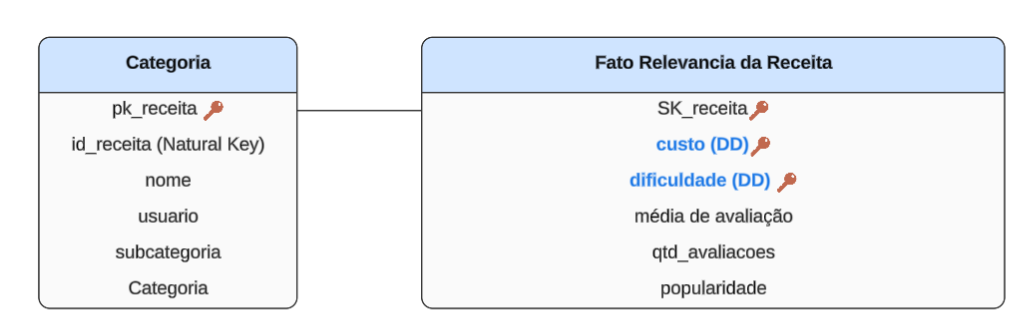
**Imagem 1**:  Modelo dimensional do Data Warehouse do site Tudo Gostoso

Nosso data warehouse é formado por duas tabelas, a dimensão Categoria e a fato Relevância da Receita. A dimensão Categoria é composta pela hierarquia entre Categoria e Subcategoria, em que uma categoria pode conter diversas subcategorias,o nome da receita, seu autor, que é um usuário do site TudoGostoso, seu identificador unitário e uma chave artificial.

A tabela fato possui sua chave composta pelas chaves de receita, estrangeira vinda da dimensão categoria, custo e dificulda. Essas duas últimas são dimensões degeneradas, logo, seus dados são armazenados diretamente na fato e não possuem uma tabela de dimensão. Seus atributos são as métricas média de avaliação, quantidade de avaliações e popularidade de uma receita.

Nesse sentido, a granularidade mínima de nosso modelo corresponde a uma receita unitária.

### Criação do modelo DW no banco de dados

In [ ]:
%%sql
CREATE TABLE dimensao_categoria (
    pk_receita SERIAL PRIMARY KEY,
    -- Chave Primária da receita (Natural Key)
    id_receita INT,
    -- Aributos
	  nome VARCHAR(255),
    usuario VARCHAR(255),
    categoria VARCHAR(100) NOT NULL,
    subcategoria VARCHAR(100)
);

CREATE TABLE fato_relevancia_receita (
    -- Chave Artificial (Surrogate Key)
    pk_receita INT,
    -- Dimensao Degenerada
    pk_dificuldade VARCHAR(50) NOT NULL,
    -- Dimensao Degenerada
    pk_custo VARCHAR(50) NOT NULL,

    -- Métricas
    media_avaliacoes DOUBLE PRECISION,
    quant_avaliacoes INTEGER,
    popularidade DOUBLE PRECISION,

    FOREIGN KEY (pk_receita) REFERENCES dimensao_categoria(pk_receita),
    PRIMARY KEY (pk_receita, pk_custo, pk_dificuldade)
);

## **ETL**
---
O processo de ETL é composto por um conjunto de etapas fundamentais no gerenciamento de um Data Warehouse, garantindo a coleta (Extract), a transformação (Transform) e o carregamento (Load) dos dados para análise. Essencial para garantir que as organizações tenham dados confiáveis e bem estruturados para a tomada de decisões baseada nos dados. Isso porque ele possibilita uma integração de múltiplas fontes de dados e melhoria na qualidade e padronização dos dados coletados.
<br><br>
Formado por três etapas, primeiro temos a coleta dos dados, que são extraídos de diversas fontes internas e/ou externas. Depois, ocorre a transformação dos dados coletados, etapa em que são limpos, padronizados e organizados. E, por fim, os dados coletados e transformados são inseridos no Data Warehouse, onde serão armazenados para consultas e análises.

A seguir temos o fluxograma do processo de ETL realizado neste projeto e a descrição de como foi cada etapa.

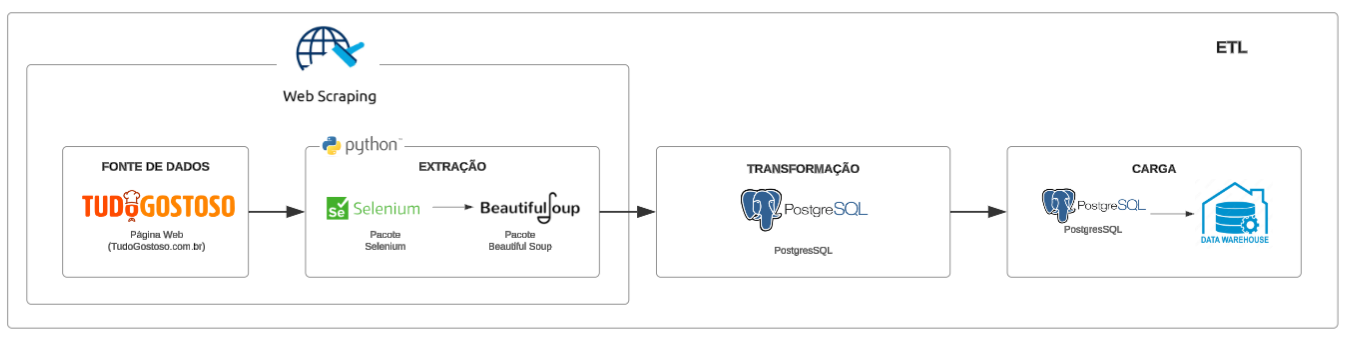

**Imagem 2**: Fluxograma da ETL

### **Extração**
Para o processo de extração, captura dos dados na fonte site TudoGosto.com.br, utilizamos o método de Web Scrapping, com as bibliotecas python `BeautifulSoup` e `selenium`. Como enfretamos o problema de o site não permitir acesso automatizado à suas páginas, instalamos o `chromedriver` e foi preciso deixar a opção de interface gráfica ativada no selenium, então, a cada acesso viamos o navegador sendo aberto.

In [ ]:
%%python
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import re

# Configurações do navegador
options = Options()
options.add_argument("--disable-gpu") # evita problemas de renderização e pode corrigir falhas inesperadas ao iniciar o navegador
options.add_argument("--no-sandbox") # desativa o modo sandbox do chrome para evitar problemas de permissão,

# Caminho do ChromeDriver
chromedriver_path = r"C:\Users\letic\Downloads\chromedriver-win64\chromedriver.exe"
driver = webdriver.Chrome(service=Service(chromedriver_path), options=options)

Além disso, como enfretamos problemas de permissão no site, para capturar os dados das receitas precisamos fixar a categoria e subcategoria que iríamos extrair pois o site não permite acessos encadeados, pois se detectado ele ativa o captcha o que impede a extração. Assim, determinamos a categoria e subcategoria que iríamos capturar e passamos o link dela para pegarmos uma lista com os links das receitas da primeira pagina.


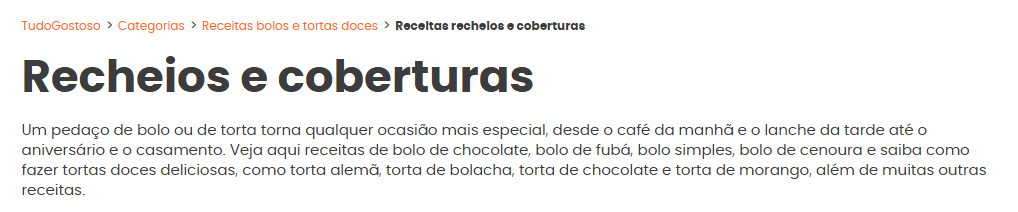
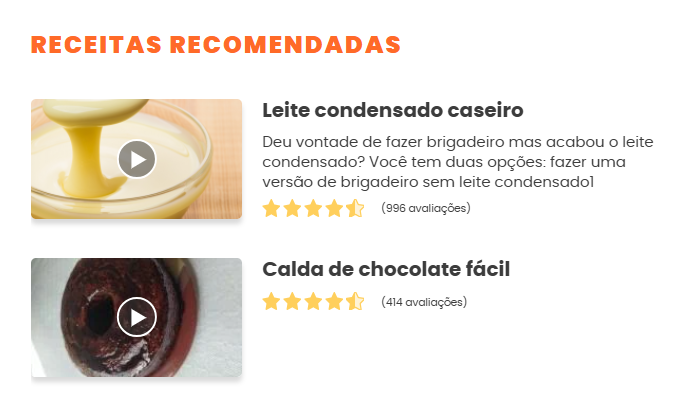
<br>
**Imagem 3**: Página de subcategoria e suas receitas

In [ ]:
%%python
# URL da subcategoria
subcategoria_url = f"https://www.tudogostoso.com.br/categorias/1112-quibe"
categoria_fixa = "Carnes"
subcategoria_fixa = "quibe"

try:
    # Acessar a página da subcategoria
    driver.get(subcategoria_url)

    # Espera até que os cards das receitas carreguem
    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CLASS_NAME, "card-listing"))
    )

    # Capturar os links das receitas na subcategoria
    html_content = driver.page_source
    soup = BeautifulSoup(html_content, "html.parser")

    #print(soup.text)

    receita_links = [
        a["href"]
        for a in soup.select("div.grid.card-listing a.card-link")
        if "href" in a.attrs and "/receita/" in a["href"]
    ]

    print(f"Links das receitas encontrados: {len(receita_links)}")
    for link in receita_links:
        print(link)

except Exception as e:
    print(f"Ocorreu um erro: {e}")

finally:
    driver.quit()

Já para capturar os dados das receitas, com os links de cada receita armazenados na lista `receitas_links`, percorremos a lista acessando cada link e extraindo os dados. Para isso também foi necessário a biblioteca `re` para usar expressões regulares em alguns casos.
<br><br>
Destaca-se, que decidimos capturar os dados das receitas apenas da primeira página de subcategoria e apenas de 4 subcategorias de cada categoria, pois cada captura demora em média 1 minuto e cada página de subcategoria contém 15 links de receita, assim para cada subcategoria de todas as categorias o tempo total de extração levaria mais de 60 horas.

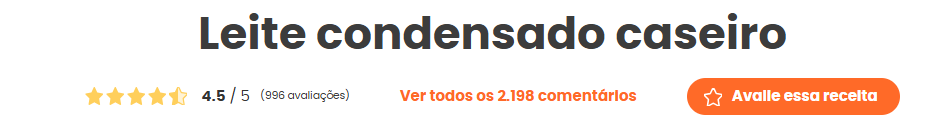

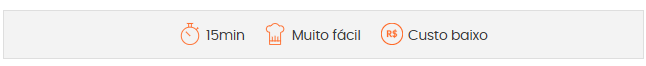

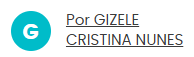

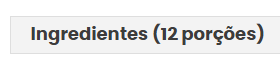

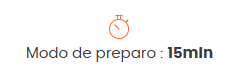

**Imagem 4**: Dados das receitas a serem capturados

In [ ]:
%%python
receitas = []
for link in receita_links:
    chromedriver_path = r"C:\Users\letic\Downloads\chromedriver-win64\chromedriver.exe"
    driver = webdriver.Chrome(service=Service(chromedriver_path), options=options)
    try:
        receita_url = f"{link}"
        driver.get(receita_url)
        WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))
        )
        # Captura o HTML
        html_content = driver.page_source
        soup = BeautifulSoup(html_content, "html.parser")
        # Extrai título da receita
        titulo = soup.find("span", class_="u-title-page u-align-center")
        titulo = titulo.text.strip() if titulo else "Nulo"
        # Extrai nota da receita
        rating_element = soup.find("span", class_="rating-grade")
        rating = (
            float(re.search(r"\d+\.\d+|\d+", rating_element.text).group())
            if rating_element
            else "Nulo"
        )
        # Extrai número de avaliações da receita
        votes_element = soup.find("span", class_="rating-votes")
        votes_text = votes_element.text.strip() if votes_element else "Nulo"
        votes = (
            float(re.search(r"\d[\d\.]*", votes_text).group())
            if votes_text != "Nulo"
            else "Nulo"
        )
        # Extrai o nome do Autor da receita
        autor_tag = soup.select_one("div.is-11.is-8-tablet.u-color-primary a")
        # Extrai o texto e remove "Por "
        if autor_tag:
            autor_nome = autor_tag.text.strip().replace("Por ", "")
        # Extrai o número de porções
        portions = "Nulo"
        ingredients_section = soup.select_one(
            ".recipe-section.recipe-ingredients > header > h2"
        )
        if ingredients_section:
            portions_text = ingredients_section.text.strip()
            portions_match = re.search(r"\((\d+)\s+por", portions_text)
            if portions_match:
                portions = float(portions_match.group(1))
        # Extrai o tempo de preparo, a dificuldade e o custo
        prep_time, difficulty, cost = "Nulo", "Nulo", "Nulo"
        recipe_blocks = soup.select(".recipe-info")
        for recipe in recipe_blocks:
            info_items = recipe.select(".recipe-info-item")
            if len(info_items) > 0:
                # Extrai o tempo de preparo
                prep_time = info_items[0].text.strip()
                hours = int(re.search(r"(\d+)h", prep_time).group(1)) if "h" in prep_time else 0
                minutes = int(re.search(r"(\d+)min", prep_time).group(1)) if "min" in prep_time else 0
                prep_time = hours * 60 + minutes
            if len(info_items) > 1:
                # Extrai a dificuldade
                difficulty = info_items[1].text.strip()
            if len(info_items) > 2:
                # Extrai o custo
                cost = info_items[2].text.strip()

        receita = {
            "Título": titulo,
            "Autor": autor_nome,
            "Nota": rating,
            "Número de avaliações": votes,
            "Categoria": categoria_fixa,
            "Subcategoria": subcategoria_fixa,
            "Número de Porções": portions,
            "Tempo de Preparo (min)": prep_time,
            "Dificuldade": difficulty,
            "Custo": cost,
            "URL": receita_url,
        }

        receitas.append(receita)

Os dados extraídos, primeiramente, foram armazenados em uma tabela intermediária `receitas` no banco de dados auxiliar, para centralizar os dados extraidos e depois facilitar os processos de transformação e carga para o data warehouse.

In [ ]:
%%sql
-- Criação da tabela intermediária no banco auxiliar
CREATE TABLE receitas (
    id SERIAL PRIMARY KEY,
    nome VARCHAR(255),
	  autor VARCHAR(255),
    nota FLOAT,
    numero_avaliacoes FLOAT,
    categoria VARCHAR(100) NOT NULL,
    subcategoria VARCHAR(100),
    numero_porcoes VARCHAR(50),
    tempo_preparo_min VARCHAR(50),
    dificuldade VARCHAR(50) CHECK (dificuldade IN ('Muito Facil','Fácil', 'Médio', 'Difícil','Muito Dificil', 'Nulo')),
    custo VARCHAR(50) CHECK (custo IN ('Custo baixo', 'Custo médio', 'Custo alto', 'Custo elevado', 'Nulo'))
);

SELECT * FROM receitas

In [ ]:
%%python
# Inserção na tabela intermediária
insert_query = """
    INSERT INTO receitas (nome, autor, nota, numero_avaliacoes, categoria, subcategoria, numero_porcoes, tempo_preparo_min, dificuldade, custo)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""
for r in receitas:
    cursor.execute(insert_query, (
        r["Título"],
        r["Autor"],
        r["Nota"],
        r["Número de avaliações"],
        r["Categoria"],
        r["Subcategoria"],
        str(r["Número de Porções"]), # como existem casos em que é 'nulo', inserimos como string
        r["Tempo de Preparo (min)"],
        r["Dificuldade"],
        r["Custo"],
    ))
    conn.commit()

Dessa maneira, após esses passos obtivemos a tabela intermediária preenchida com os dados necessários para carregar o data warehouse, mas antes precisamso aplicar alguns processos de transformação e limpeza nos dados. Observa-se que um deles já foi aplicado na extração, pois para o tempo de preparo transformamos todos para minutos, a fim de mante-los padronizados.

### **Transformação**
Para operações de limpeza e transformação começamos filtrando já nas páginas de receitas do site quais informações seriam dispensáveis para o nosso projeto, como a lista de utensílios de cada receita. Após determinar os dados que iríamos extrair, definimos como organizar essa extração e foi necessário o uso de uma tabela intermediária para armazenar os dados extraídos direto do site e nesta tabela foram aplicadas operações de transformação e limpeza. Os processos aplicados foram listados a seguir.
<br><br>
A normalização dos textos para que todos ficassem em letras minúsculas e, como os valores numéricos dos atributos `tempo de preparo` e `número de porções` foram capturados como strings por existir casos em que eles eram nulos, então, na captura foi atribuído a esses casos o valor 'Nulo', sendo transformados em null. Para os valores da coluna `custo` removemos a string 'custo' e deixamos apenas o nível, pois os valores vindos da extração eram 'custo médio' e pós transformação ficaram 'médio', pois o valor já está na coluna `custo`. E na coluna `numero_avaliacoes` transformamos para o tipo inteiro pois não tem como o número de avalição de uma receita ser um número real, como 0,5 avaliações.

In [ ]:
%%sql
-- Normalização de strings para minúsculo
UPDATE receitas
  SET nome = LOWER(nome),
  autor = LOWER(autor),
  categoria = LOWER(categoria),
  subcategoria = LOWER(subcategoria),
  dificuldade = LOWER(dificuldade),
  custo = LOWER(custo);

-- String 'Nulo' para o valor NULL
UPDATE receitas
  SET numero_porcoes = NULL WHERE numero_porcoes = 'nulo';

-- Remove a palavra 'Custo' dos valores da coluna custo
UPDATE receitas
  SET custo = REPLACE(custo, 'custo ', '');

-- Transforma o tipo de Número de avaliações para inteiro
ALTER TABLE receitas
ALTER COLUMN numero_avaliacoes TYPE INTEGER USING numero_avaliacoes::INTEGER;

Para tratar valores nulos, como existiam em custo, dificuldade, tempo de preparo e número de porções, pois não foram citados na página da receita, determinamos que cada coluna seria tratada de um modo diferente.
<br><br>
Para a coluna `custo` calculamos a moda dos níveis de custos das receitas de mesma subcategoria e essa moda é o valor que substitui os valoes nulos da coluna. Isso porque entendemos que parte do custo de uma receita está relacionado ao valor dos ingredientes e receitas de mesma subcategoria tendem a ter uma lista de ingredientes parecida e por isso de custo próximo.
<br><br>
Destaca-se que em situações de empate na moda, ela é determinada com o valor mais alto, então em casos como empate entre custo médio e baixo, o valor escolhido é o médio. E quando não há moda a ser calculada definimos que o valor de custo é 'não especificado'.

In [ ]:
%%sql
-- Tratamento de valor nulo: Coluna custo
UPDATE receitas AS r
    SET custo = moda.moda_custo
    FROM (
        SELECT subcategoria,
               MODE() WITHIN GROUP (ORDER BY custo) AS moda_custo -- funciona pra string
        FROM receitas
        WHERE custo IS NOT NULL AND custo != 'nulo'
        GROUP BY subcategoria
    ) AS moda
    WHERE r.subcategoria = moda.subcategoria AND r.custo = 'nulo';

UPDATE receitas SET custo = 'não especificado' WHERE custo = 'nulo'

Para coluna `numero_porcoes` definimos que onde o valor é nulo, ele será padronizado para 'não especificado'.

In [ ]:
%%sql
UPDATE receitas
SET numero_porcoes = 'não especificado'
WHERE numero_porcoes IS NULL OR numero_porcoes = 'nulo';

Para tratar `tempo_preparo_min` consideramos pegar a moda dos valores de tempo da mesma subcategoria. Isso porque por serem da mesma subcategoria, os pratos tendem a ser semelhantes e por isso o tempo pode ser parecido.

In [ ]:
%%sql
UPDATE receitas AS r
SET tempo_preparo_min = moda.moda_tempo_preparo
FROM (
      SELECT subcategoria, MODE() WITHIN GROUP (ORDER BY tempo_preparo_min) AS moda_tempo_preparo -- funciona pra string
      FROM receitas
      WHERE tempo_preparo_min IS NOT NULL AND tempo_preparo_min != 'nulo'
      GROUP BY subcategoria
    ) AS moda
WHERE r.subcategoria = moda.subcategoria AND r.tempo_preparo_min = 'nulo';

Após o tratamento dos valores nulos em tempo de preparo transformamos seu tipo para inteiro. Assim, seus valores são minutos em números inteiros, como 15, 60 ou 120 minutos.

In [ ]:
%%sql
ALTER TABLE receitas
ALTER COLUMN tempo_preparo_min TYPE INTEGER USING tempo_preparo_min::INTEGER;

Para a coluna dificuldade definimos três situações e informações necessárias para tratar os valores nulos.

Primeira situação, se a dificuldade é nula mas há tempo de preparo na receita, usamos a moda dos níveis de dificuldade das receitas de mesma subcategoria que tenham tempo de preparo dentro do intervalo: `[tempo_de_preparo - 20 min, tempo_de_preparo  + 20 min]`. O segundo caso é se o tempo de preparo da receita não está no intervalo, então, calculamos a moda dos níveis de dificuldade das receitas de mesma subcategoria. Já o terceiro caso é quando as outras receitas de mesma subcategoria também tem sua dificuldade como nula, assim, não temos as informações para determinar uma moda da dificuldade, então, padronizamos as dificuldades desses casos como 'não especificado'.

In [ ]:
%%sql
UPDATE receitas AS r
SET dificuldade = COALESCE(
    -- 1ª Tentativa: Moda dentro do intervalo de ±20 minutos
    (
        SELECT MODE() WITHIN GROUP (ORDER BY r2.dificuldade)
        FROM receitas AS r2
        WHERE r2.subcategoria = r.subcategoria
        AND r2.dificuldade != 'nulo' AND dificuldade != 'não especificado'
        AND r2.tempo_preparo_min BETWEEN (r.tempo_preparo_min - 20)
                                     AND (r.tempo_preparo_min + 20)
    ),
    -- 2ª Tentativa: Moda sem considerar o intervalo de tempo
    (
        SELECT MODE() WITHIN GROUP (ORDER BY r3.dificuldade)
        FROM receitas AS r3
        WHERE r3.categoria = r.categoria
        AND r3.subcategoria = r.subcategoria
        AND r3.dificuldade != 'nulo' AND r3.dificuldade != 'não especificado'
    ),
    -- 3ª Opção: Se tudo falhar, definimos como 'não especificado'
    'não especificado'
)
WHERE r.dificuldade IS NULL OR r.dificuldade = 'nulo';

Por fim, com uma das nossas métricas na tabela fato é a popularidade de uma receita, utilizamos da etapa de transformação para estudar como essa métrica seria calculada. O site IMDb usa uma média ponderada para evitar que filmes com poucos votos tenham notas muito altas ou baixas, por exemplo. Assim, consideramos para o cálculo: a nota da receita, o número de avaliações, a nota média de todas as receitas no banco de dados e o número mínimo de avaliações a  considerar. Em nosso caso, avaliando os quartis 1 e 3 e a mediana de nosso conjunto de receitas, o nosso número mínimo escolhido foi 100.

In [ ]:
%%sql
SELECT nome, categoria, subcategoria, nota, numero_avaliacoes, popularidade FROM
(SELECT nome,categoria,subcategoria,nota,numero_avaliacoes,
    (
        (numero_avaliacoes / (numero_avaliacoes + 100.0)) * nota +
        (100.0 / (numero_avaliacoes + 100.0)) * (SELECT AVG(nota) FROM receitas)
    ) AS popularidade
FROM receitas) AS t1
ORDER BY t1.popularidade DESC

SELECT (numero_avaliacoes) FROM receitas

SELECT
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY numero_avaliacoes) AS Q1,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY numero_avaliacoes) AS Mediana,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY numero_avaliacoes) AS Q3,
    AVG(numero_avaliacoes) AS Media_Avaliacoes
FROM receitas;

-- Mediana (𝑄2): Indica um número típico de avaliações.
-- Q1 (1º quartil): 25% das receitas têm menos que esse número de avaliações.
-- Q3 (3º quartil): 75% das receitas têm menos que esse número de avaliações
-- Se a mediana está abaixo de 10, C=10 pode ser um bom valor
-- Se a média está em torno de 20, considerar C=20 faz sentido
-- Se 𝑄3 estiver acima de 50, receitas populares têm muito mais avaliações → pode valer a pena usar C=30 ou C=50.

Analisando o resultado dessa consulta, chegamos em níveis de popularidades coerentes com as notas das receitas. Então, utilizamos esse cálculo na etapa de carga, para calcular a métrica popularidade na tabela fato.

Com as transformações realizadas na tabela auxiliar, iniciamos os processos da etapa de carga.

### **Carga**
Com os dados extraídos e transformados, desenvolvemos a etapa de inserir esses  dados da tabela auxiliar no data warehouse. Como utilizamos uma tabela auxiliar para a extração e transformação, e aprendemos em aula, utilizamos o `dblink` para conectar o nosso banco auxilar ao banco com o data warehouse.

Primeiro, preenchemos a tabela dimensão Categoria com os dados da tabela auxiliar e sua chave é serial

In [ ]:
%%sql
INSERT INTO dimensao_categoria (id_receita, nome, usuario, categoria, subcategoria)
SELECT *
FROM dblink('dbname=Banco_receitas_auxiliar user=postgres password=macaco10',
            'SELECT id,nome, autor, categoria, subcategoria
			 FROM receitas
			 ORDER BY categoria, subcategoria')
AS t1(id INT, nome TEXT, usuario TEXT, categoria TEXT, subcategoria TEXT);

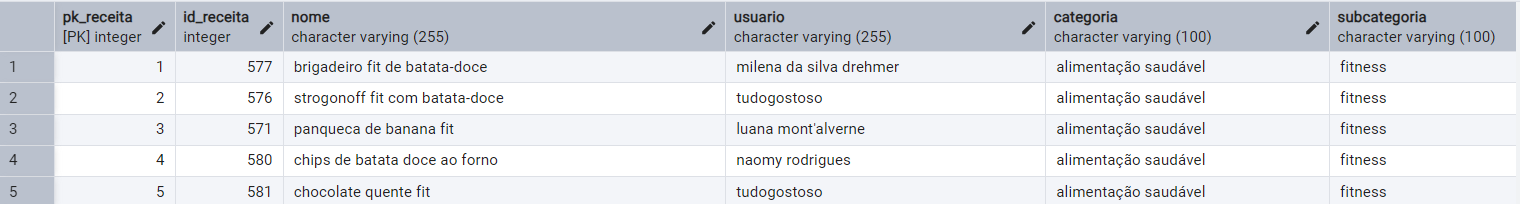

Com a dimensão povoada, construímos uma tabela temporária para armazenar os dados que serão utilizados para povoar a fato.

In [ ]:
%%sql
CREATE TEMPORARY TABLE temp_fato_popularidade (
	id_receita INT,
	pk_receita INT,
	pk_dificuldade TEXT,
	pk_custo TEXT,
	nome TEXT,
	usuario TEXT,
	nota DOUBLE PRECISION,
	qtd_avaliacoes INT,
	categoria TEXT,
	subcategoria TEXT,
	tempo_preparo_min INT,
	dificuldade TEXT,
	custo TEXT,
	popularidade DOUBLE PRECISION
);

Povoamos a tabela temporária com os dados das tabelas dimensão categoria e tabela auxiliar do outro banco. Destaca-se que nessa consulta de carga temos a consulta para obter a métrica popularidade, testada na etapa de transformação.

In [ ]:
%%sql
--inserindo na tabela temporária (a partir do BD auxiliar) os dados a serem comparados depois com as dimensões (para pegar as PKs para depois passar para a tabela fato), além do cálculo das métricas (que vão ser passados depois para a tabela fato também)
INSERT INTO temp_fato_popularidade (id_receita, nome, usuario, nota, qtd_avaliacoes, categoria, subcategoria, tempo_preparo_min, dificuldade, custo, popularidade)
SELECT *
FROM dblink('dbname=Banco_receitas_auxiliar user=postgres password=macaco10',
            'SELECT id, nome, autor, nota, numero_avaliacoes, categoria, subcategoria, tempo_preparo_min, dificuldade, custo,
			 ((numero_avaliacoes / (numero_avaliacoes + 100.0)) * nota +(100.0 / (numero_avaliacoes + 100.0)) * (SELECT AVG(nota) FROM receitas)) AS popularidade
             FROM receitas')
AS t1(id INT, nome TEXT, autor TEXT, nota DOUBLE PRECISION, numero_avaliacoes INT, categoria TEXT, subcategoria TEXT, tempo_preparo_min INT, dificuldade TEXT, custo TEXT, popularidade DOUBLE PRECISION);


Por fim, a partir da tabela temporária, povoamos a tabela fato, já com a métrica popularidade calculada. Definindo sua pk_receita a partir da pk_receita da tabela dimensão categoria, verificando onde os dados são correspondentes.

In [ ]:
%%sql
INSERT INTO fato_relevancia_receita(pk_receita, pk_dificuldade, pk_custo, media_avaliacoes, quant_avaliacoes, popularidade)
SELECT DISTINCT ON (t.id_receita) c.pk_receita, t.dificuldade, t.custo, t.nota, t.qtd_avaliacoes, t.popularidade
FROM temp_fato_popularidade t
JOIN dimensao_categoria c
ON c.nome = t.nome
AND c.usuario = t.usuario
AND c.categoria = t.categoria
AND c.subcategoria = t.subcategoria
AND c.id_receita = t.id_receita;

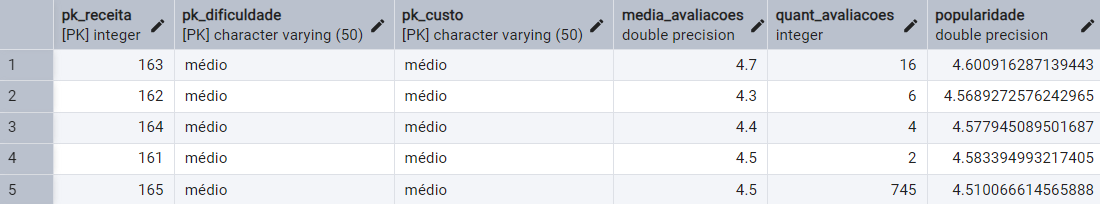

Após as etapas de ETL nosso data warehouse está povoado, com dados originados do site TudoGostoso, limpos e padronizados, podemos realizar consultas a fim de realizar análises.

## **REALIZAÇÃO DAS CONSULTAS**
---

Esta seção apresentará as consultas realizadas no DW desenvolvido e seus resultados

### Consulta 1: **Qual subcategoria X com dificuldade Y e custo Z com mais receitas unitárias?**



In [ ]:
%%sql
--CONSULTA 1:
-- Qual subcategoria com dificuldade Y e custo Z com mais receitas unitárias
SELECT categoria, subcategoria, COUNT(*) as qtd_receitas
FROM fato_relevancia_receita f JOIN dimensao_categoria d ON d.pk_receita = f.pk_receita
WHERE pk_dificuldade LIKE 'fácil' AND pk_custo LIKE 'baixo'
GROUP BY categoria, subcategoria
HAVING COUNT(*) IN (SELECT max(qtd_receitas) AS maximo_receitas
					FROM (SELECT categoria, subcategoria, COUNT(*) as qtd_receitas
						  FROM fato_relevancia_receita f JOIN dimensao_categoria d ON d.pk_receita = f.pk_receita
						  WHERE pk_dificuldade LIKE 'fácil' AND pk_custo LIKE 'baixo'
						  GROUP BY categoria, subcategoria) as t1)

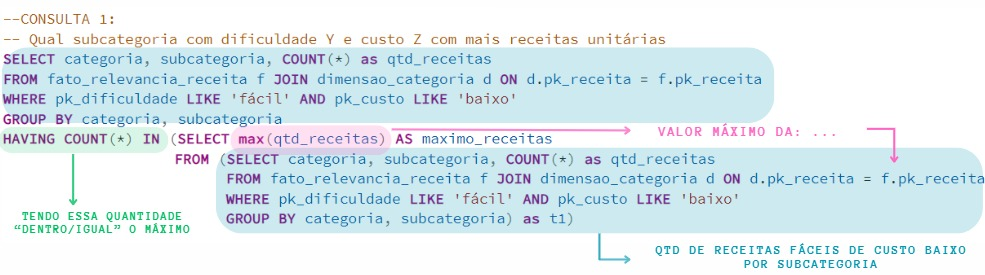

In [ ]:
%%sql
-- VARIAÇÃO
SELECT categoria, subcategoria, COUNT(*) as qtd_receitas
FROM fato_relevancia_receita f JOIN dimensao_categoria d ON d.pk_receita = f.pk_receita
WHERE pk_dificuldade LIKE 'fácil' AND pk_custo LIKE 'baixo'
GROUP BY categoria, subcategoria
ORDER BY qtd_receitas DESC

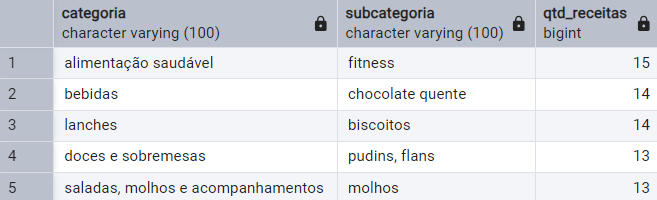

### Consulta 2: **Dada duas categorias comparar o nível de dificuldade delas.**

In [ ]:
%%sql
SELECT categoria, COALESCE(
  (SELECT MODE() WITHIN GROUP (ORDER BY pk_dificuldade)
    FROM fato_relevancia_receita f2
    JOIN dimensao_categoria d2 ON d2.pk_receita = f2.pk_receita
    WHERE f2.pk_dificuldade != 'não especificado'
      AND d2.categoria = d.categoria),
    'não especificado') AS dificuldade_mais_comum
FROM dimensao_categoria d
WHERE categoria IN ('aves', 'carnes')
GROUP BY categoria;

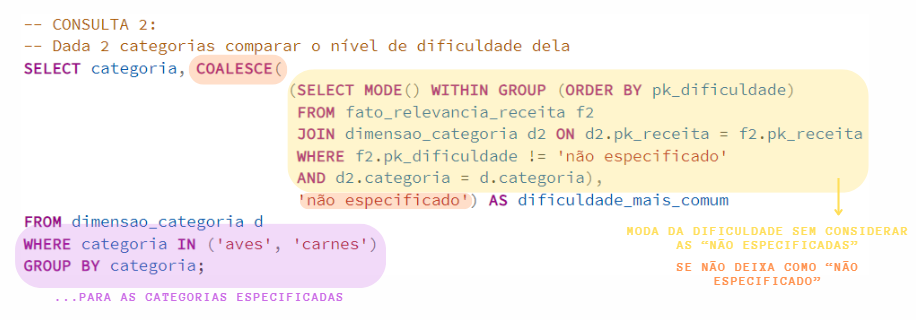

In [ ]:
%%sql
-- VARIAÇÃO
SELECT categoria, COALESCE(
           					(SELECT MODE() WITHIN GROUP (ORDER BY pk_dificuldade)
            				 FROM fato_relevancia_receita f2
            				 JOIN dimensao_categoria d2 ON d2.pk_receita = f2.pk_receita
            				 WHERE f2.pk_dificuldade != 'não especificado'
              				 AND d2.categoria = d.categoria),
           					 'não especificado') AS dificuldade_mais_comum
FROM dimensao_categoria d
GROUP BY categoria;


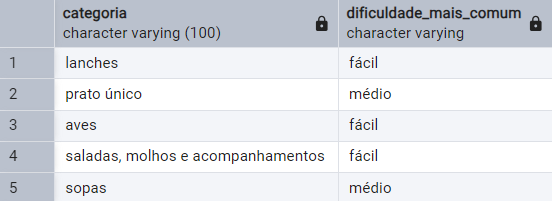

### Consulta 3: **Qual o ranking de subcategoria com mais avaliações, suas médias de avaliação e sua popularidade?**

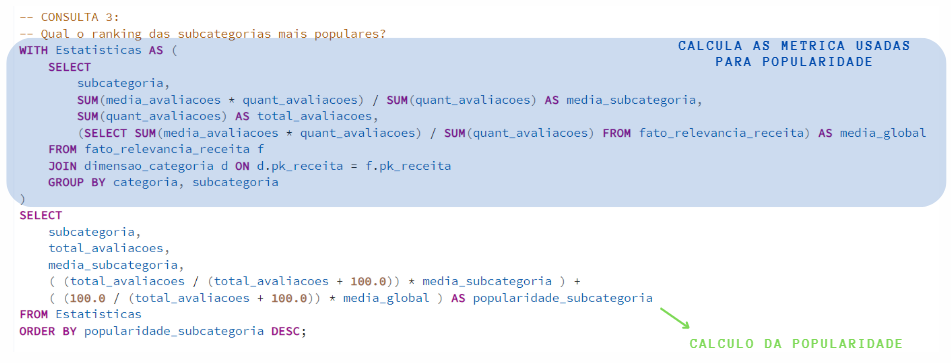

In [ ]:
%%sql
--CONSULTA 3:
-- Qual o ranking de subcategorias mais populares?
WITH Estatisticas AS (
    SELECT
        subcategoria,
        SUM(media_avaliacoes * quant_avaliacoes) / SUM(quant_avaliacoes) AS media_subcategoria,
        SUM(quant_avaliacoes) AS total_avaliacoes,
        (SELECT SUM(media_avaliacoes * quant_avaliacoes) / SUM(quant_avaliacoes) FROM fato_relevancia_receita) AS media_global
    FROM fato_relevancia_receita f
    JOIN dimensao_categoria d ON d.pk_receita = f.pk_receita
    GROUP BY categoria, subcategoria
)
SELECT
    subcategoria,
    total_avaliacoes,
    media_subcategoria,
    ( (total_avaliacoes / (total_avaliacoes + 100.0)) * media_subcategoria ) +
    ( (100.0 / (total_avaliacoes + 100.0)) * media_global ) AS popularidade_subcategoria
FROM Estatisticas
ORDER BY popularidade_subcategoria DESC;

-- OBS: Ranking das categorias mais populares
WITH Estatisticas AS (
    SELECT
        categoria,
        SUM(media_avaliacoes * quant_avaliacoes) / SUM(quant_avaliacoes) AS media_categoria,
        SUM(quant_avaliacoes) AS total_avaliacoes,
        (SELECT SUM(media_avaliacoes * quant_avaliacoes) / SUM(quant_avaliacoes) FROM fato_relevancia_receita) AS media_global
    FROM fato_relevancia_receita f
    JOIN dimensao_categoria d ON d.pk_receita = f.pk_receita
    GROUP BY categoria
)
SELECT
    categoria,
    total_avaliacoes,
    media_categoria,
    ( (total_avaliacoes / (total_avaliacoes + 100.0)) * media_categoria ) +
    ( (100.0 / (total_avaliacoes + 100.0)) * media_global ) AS popularidade_categoria
FROM Estatisticas
ORDER BY popularidade_categoria DESC;

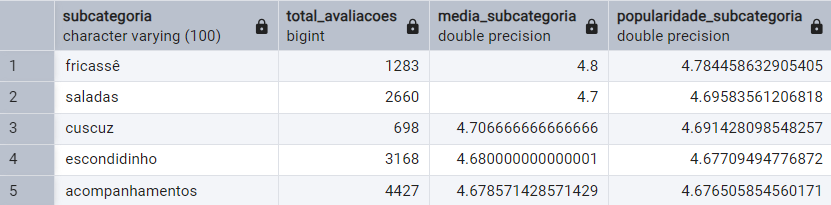

## **CONSIDERAÇÕES FINAIS**
---
Neste projeto aprendemos, ainda mais, a diferença entre um banco relacional e um data warehouse. Já na etapa de estruturação nossa visão sobre as cosultas e modelo a ser projetado precisaram ser diferentes, justamente por ter a necessidade de Business Inteligence.


Desse modo, o DW permite a realização de análises mais complexas, que envolvem grandes volumes de dados, agregação e consultas analíticas, o que auxiliam na tomada de decisões estratégicas do gerente que vier a utilizá-lo. Tendo seus dados carregados em lotes.


Na etapa do Web Scrapping (Extração dos dados) tivemos dificuldades para acessar o site, por conta do acesso ser automatizado e assim ativar captcha, conseguimos resolver o problema ao gerar uma conexão para cada acesso de link de receita, o que levou mais tempo de extração, levando a uma diminuição do escopo de nossos dados. E entendemos essa característica de fontes externas do DW.


Tanto na etapa de transformação quanto na de carga, não tivemos grandes problemas e realizamos via SQL, utilizando o auxilio de um banco auxiliar e uma tabela temporária.

## **FONTES**
---
Nesta seção estão as fontes que utilizamos para o desenvolvimento desta fase do projeto.
1. TudoGostoso: as receitas que todo mundo faz. Disponível em: <https://www.tudogostoso.com.br>.
2. Lucidchart: Diagramação com inteligência. Disponível em: <https://www.lucidchart.com/pages/pt>.
3. PostgreSQL 9.4.26 Documentation. Chapter 9. Functions and Operators. Disponível em: <https://www.postgresql.org/docs/9.4/functions-aggregate.html#FUNCTIONS-ORDEREDSET-TABLE>
4. PostgreSQL Tutorial / Getting Started / Change Column's Data Type. Disponível em:<br> <https://neon.tech/postgresql/postgresql-tutorial/postgresql-change-column-type>
5. PostgreSQL 8.1.23 Documentation. 9.4. String Functions and Operators. Disponível em: <https://www.postgresql.org/docs/8.1/functions-string.html>
6. How do you calculate the IMDb rating displayed on a title page?. Disponível em:<br> <https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?ref_=helpms_helpart_inline#>
7. WITH common_table_expression (Transact-SQL). Disponível em:<br> <https://learn.microsoft.com/pt-br/sql/t-sql/queries/with-common-table-expression-transact-sql?view=sql-server-ver16&viewFallbackFrom=sql-server-ver16%2F>

## **BACKUP DO ESQUEMA DO DW**
---
Apêndice do backup

In [ ]:
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Arquivo anexado: [{filename}](./{filename})")


Saving Banco_receitas_auxiliar.backup to Banco_receitas_auxiliar.backup
Saving DW_tudoGostoso.backup to DW_tudoGostoso.backup
Arquivo anexado: [Banco_receitas_auxiliar.backup](./Banco_receitas_auxiliar.backup)
Arquivo anexado: [DW_tudoGostoso.backup](./DW_tudoGostoso.backup)
